# Online Gaming Behavior

### Por que é adequada à regressão:

- Possui múltiplas variáveis explicativas (demografia, hábito de jogo, engajamento).
- Possui alvos contínuos viáveis: AvgSessionDurationMinutes (10–179 min) e/ou PlayTimeHours (0.024–23.96 h).
- Aplicabilidade prática: previsão de duração média de sessão ajuda a dimensionar servidores, matchmaking e personalização.

### Riscos e mitigação:

- Distribuição possivelmente assimétrica → considerar log1p no alvo e inversão na predição.
- Categóricas com cardinalidade moderada → One-Hot Encoding com handle_unknown='ignore'.


## Pré-processamento

Carregamento dataset

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/online_gaming_insights.csv")


Inspeção inicial

In [31]:
df.head()
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
count,40034.000000,40034.000000,40034,40034,40034,40034.000000,40034.000000,40034,40034.000000,40034.000000,40034.000000,40034.000000,40034
unique,NaN,NaN,2,4,5,NaN,NaN,3,NaN,NaN,NaN,NaN,3
top,NaN,NaN,Male,USA,Sports,NaN,NaN,Easy,NaN,NaN,NaN,NaN,Medium
freq,NaN,NaN,23959,16000,8048,NaN,NaN,20015,NaN,NaN,NaN,NaN,19374
mean,29016.500000,31.992531,NaN,NaN,NaN,12.024365,0.200854,NaN,9.471774,94.792252,49.655568,24.526477,NaN
std,11556.964675,10.043227,NaN,NaN,NaN,6.914638,0.400644,NaN,5.763667,49.011375,28.588379,14.430726,NaN
min,9000.000000,15.000000,NaN,NaN,NaN,0.000115,0.000000,NaN,0.000000,10.000000,1.000000,0.000000,NaN
25%,19008.250000,23.000000,NaN,NaN,NaN,6.067501,0.000000,NaN,4.000000,52.000000,25.000000,12.000000,NaN
50%,29016.500000,32.000000,NaN,NaN,NaN,12.008002,0.000000,NaN,9.000000,95.000000,49.000000,25.000000,NaN
75%,39024.750000,41.000000,NaN,NaN,NaN,17.963831,0.000000,NaN,14.000000,137.000000,74.000000,37.000000,NaN


Tipagem de colunas

In [32]:
num_cols = [
    "Age","PlayTimeHours","SessionsPerWeek","AvgSessionDurationMinutes",
    "PlayerLevel","AchievementsUnlocked"
]
cat_cols = [
    "Gender","Location","GameGenre","GameDifficulty","EngagementLevel",
    "InGamePurchases"
]

Define o alvo (média de duração das sessões)

In [33]:
target = "AvgSessionDurationMinutes"

Valores faltantes

In [34]:
df.isna().sum()

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

Valores duplicados

In [35]:
df.duplicated().sum()

0

Separa X, y e remove colunas que não são úteis

In [36]:
drop_cols = ["PlayerID", target]
X = df.drop(columns=drop_cols)
y = df[target]

Tratamento de colunas com ColumnTransformer e pipelines

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_cols_X = [c for c in num_cols if c != target]
cat_cols_X = cat_cols

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_X),
        ("cat", cat_pipe, cat_cols_X)
    ]
)

## Análise exploratória

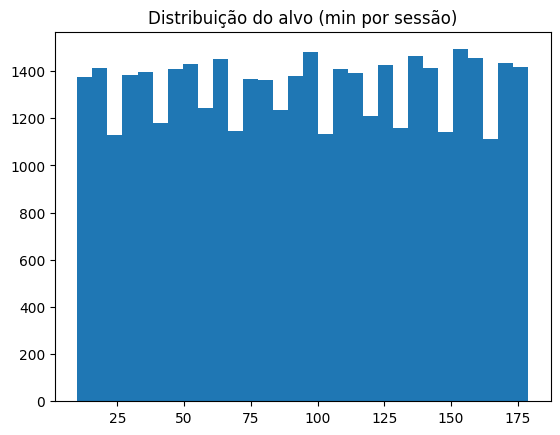

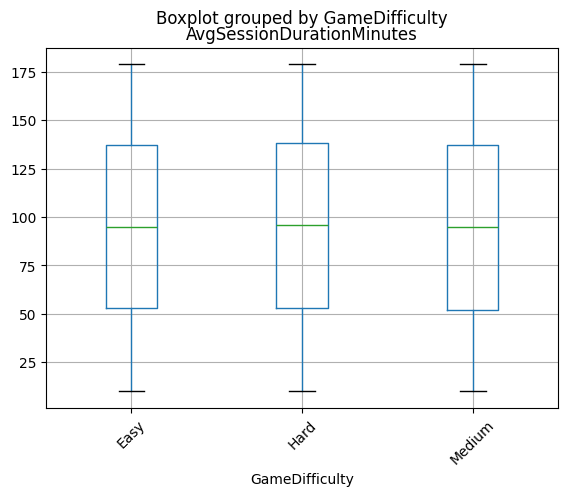

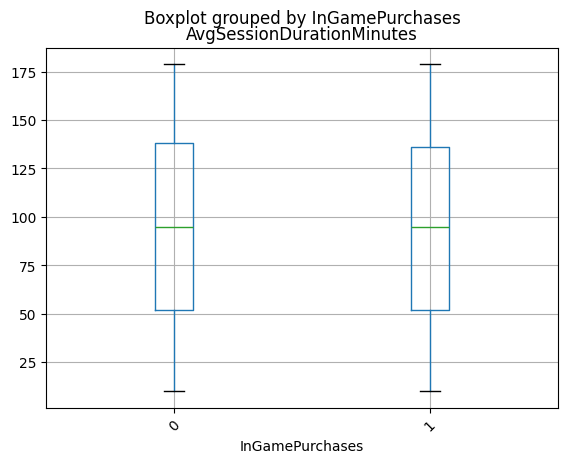

In [38]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30); plt.title("Distribuição do alvo (min por sessão)"); plt.show()

df[num_cols].corr()

df.boxplot(column=target, by="GameDifficulty", rot=45); plt.show()
df.boxplot(column=target, by="InGamePurchases", rot=45); plt.show()

## Modelos de regressão

Funções utiliárias

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def eval_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:25s} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    return {"MAE":mae, "RMSE":rmse, "R2":r2}

results = {}


Baseline (média)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

baseline = Pipeline([("prep", preprocess), ("model", DummyRegressor(strategy="mean"))])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
results["dummy_mean"] = eval_regression(y_test, pred, "Baseline (Mean)")


Baseline (Mean)           | MAE: 42.579 | RMSE: 49.176 | R2: -0.000


### KNN

In [49]:
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ("prep", preprocess),
    ("model", KNeighborsRegressor(n_neighbors=15, weights="distance"))
])
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
results["knn"] = eval_regression(y_test, pred, "KNN Regressor")

KNN Regressor             | MAE: 32.581 | RMSE: 39.667 | R2: 0.349


### Árvore de Decisão

In [50]:
from sklearn.tree import DecisionTreeRegressor

dt = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(max_depth=6, random_state=42))
])
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
results["decision_tree"] = eval_regression(y_test, pred, "Decision Tree Regressor")

Decision Tree Regressor   | MAE: 29.076 | RMSE: 36.495 | R2: 0.449


### Regressão linear

In [51]:
from sklearn.linear_model import LinearRegression

lin = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])
lin.fit(X_train, y_train)
pred = lin.predict(X_test)
results["linear"] = eval_regression(y_test, pred, "Linear Regression")

Linear Regression         | MAE: 30.939 | RMSE: 38.983 | R2: 0.372


### Regressão Logística

In [52]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector

n_bins = 5
kbd = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
y_bin_train = kbd.fit_transform(y_train.to_numpy().reshape(-1,1)).astype(int).ravel()
bin_edges = kbd.bin_edges_[0]
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

logreg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=200))
])
logreg.fit(X_train, y_bin_train)

proba = logreg.predict_proba(X_test)
y_pred_log = (proba * bin_centers).sum(axis=1)

results["logistic_reg_as_reg"] = eval_regression(y_test, y_pred_log, "Logistic (bins→expectation)")


Logistic (bins→expectation) | MAE: 30.301 | RMSE: 37.636 | R2: 0.414


### Naive Bayes

In [53]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = Pipeline([
    ("prep", preprocess),
    ("model", GaussianNB())
])
gnb_clf.fit(X_train, y_bin_train)

proba = gnb_clf.named_steps["model"].predict_proba(
    gnb_clf.named_steps["prep"].transform(X_test)
)
y_pred_gnb = (proba * bin_centers).sum(axis=1)

results["naive_bayes_as_reg"] = eval_regression(y_test, y_pred_gnb, "GaussianNB (bins→expectation)")

GaussianNB (bins→expectation) | MAE: 35.833 | RMSE: 46.326 | R2: 0.113


### Redes Neurais

In [55]:
from sklearn.neural_network import MLPRegressor

mlp = Pipeline([
    ("prep", preprocess),
    ("model", MLPRegressor(hidden_layer_sizes=(64,32), activation="relu",
                           learning_rate_init=0.001, max_iter=1000, random_state=42))
])
mlp.fit(X_train, y_train)
pred = mlp.predict(X_test)
results["mlp"] = eval_regression(y_test, pred, "Neural Network (MLPRegressor)")

Neural Network (MLPRegressor) | MAE: 29.058 | RMSE: 36.569 | R2: 0.447


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### Análise de resultados

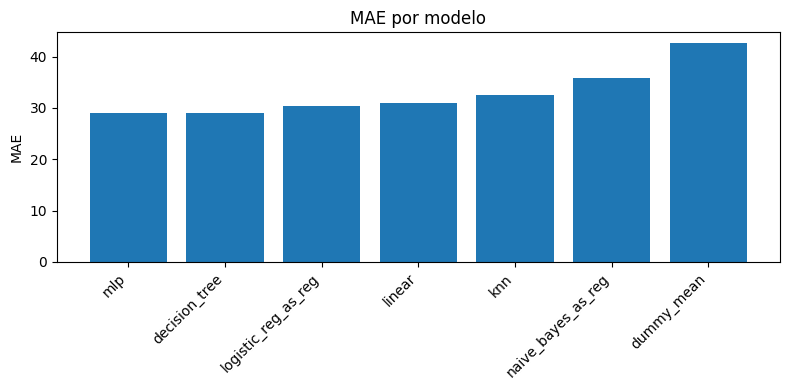

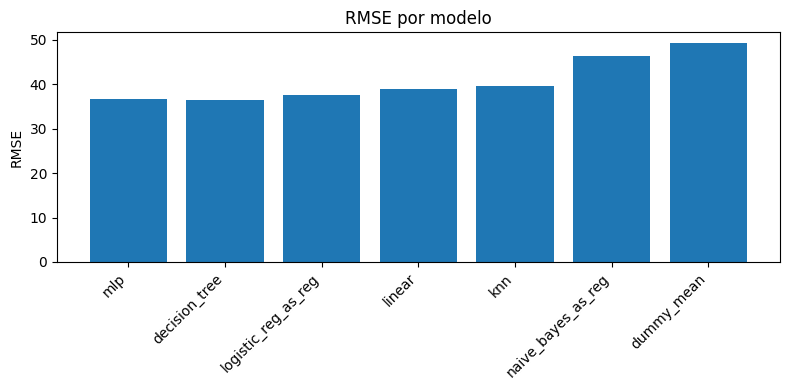

,MAE,RMSE,R2
mlp,29.058482,36.569460,0.446984
decision_tree,29.076441,36.495199,0.449227
logistic_reg_as_reg,30.301493,37.636364,0.414245
linear,30.939334,38.983317,0.371568
knn,32.581215,39.667265,0.349323
naive_bayes_as_reg,35.833064,46.326420,0.112521
dummy_mean,42.579324,49.175975,-0.000016


In [56]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("MAE")

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["MAE"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("MAE por modelo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["RMSE"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("RMSE por modelo")
plt.tight_layout()
plt.show()

display(results_df)